In [160]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from math import sqrt

[nltk_data] Downloading package punkt to /Users/Student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)




In [162]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [163]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [164]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)


In [165]:
#disc=df['newComments'].values.tolist()
#vect.fit(disc)
#columns_name=vect.get_feature_names()
#disc_vec=vect.fit_transform(disc)

In [166]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
#disc_vec_tfidf = tfidf_transformer.fit_transform(disc_vec)

In [167]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']

X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.3)
X_train_onehot = vect.fit_transform(X_train_kera)
X_train_onehot = tfidf_transformer.fit_transform(X_train_onehot)
X_test_onehot = vect.transform(X_test_kera)
X_test_onehot = tfidf_transformer.fit_transform(X_test_onehot)


In [168]:
#X_test_kera[0:,0].shape,y_test_kera.shape,X_train_kera.shape

In [169]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train_onehot,y_train_kera)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [170]:
y_pred_LR=LR.predict(X_test_onehot)

In [171]:
from sklearn.metrics import mean_squared_error,r2_score
LR_RMSE = sqrt(mean_squared_error(y_test_kera,y_pred_LR))
LR_RMSE

0.2142534683643993

In [172]:
#from scipy.sparse import csr_matrix
#X_train_onehot = csr_matrix((X_train_onehot.data, X_train_onehot.indices, X_train_onehot.indptr), shape=(10399,1))
#y_test_kera = csr_matrix((y_test_kera.data, y_test_kera.indices, y_test_kera.indptr), shape=(10399,1))

Coefficients: 
 [ 0.09173779  0.08505815 -0.03585108 ...  0.06809985  0.06453697
 -0.4695962 ]
Mean squared error: 0.05
Variance score: 0.15


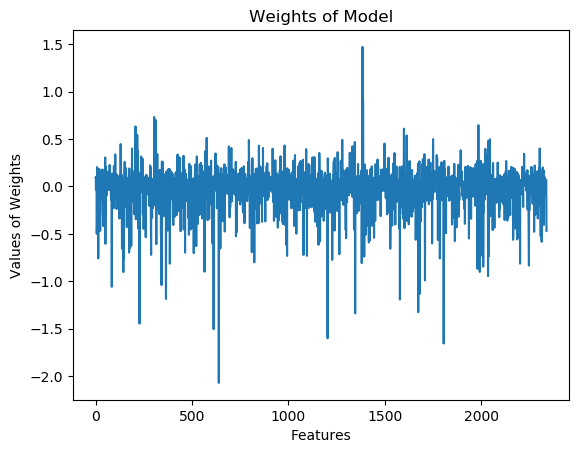

In [173]:
print('Coefficients: \n', LR.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test_kera, y_pred_LR))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_kera, y_pred_LR))

plt.plot(LR.coef_)
plt.xlabel('Features')
plt.ylabel('Values of Weights')
plt.title('Weights of Model')
# Plot outputs
#plt.scatter(a[1:10400],y_pred,color='black')
#plt.scatter(X_train_onehot[:,0],y_test_kera,color='black')
#plt.plot(X_train_onehot[:,0], y_pred, color='blue')

#plt.xticks(())
#plt.yticks(())

plt.show()

In [174]:
LR_ypred_1 = []
LR_ypred_0 = []

In [175]:
for i in y_pred_LR:
    if i >0.9:
        LR_ypred_1.append(i)
    else:
        LR_ypred_0.append(i)

In [176]:
len(LR_ypred_0),len(LR_ypred_1)

(2490, 7909)

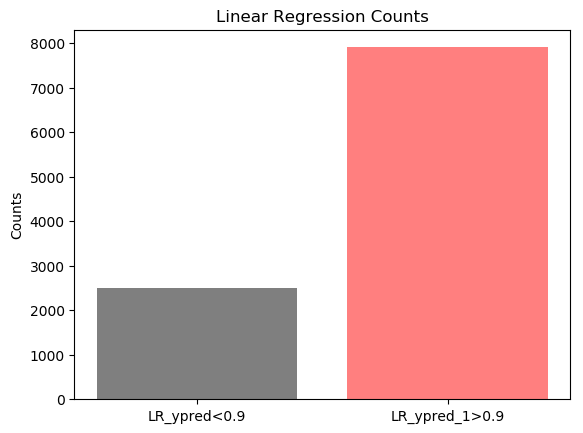

In [177]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR_ypred<0.9', 'LR_ypred_1>0.9')
y_pos = np.arange(len(objects))
performance = [len(LR_ypred_0),len(LR_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Linear Regression Counts')
 
plt.show()

In [178]:
from sklearn.linear_model import SGDClassifier
SGDClassifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGDClassifier.fit(X_train_onehot, y_train_kera)   

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [179]:
y_pred_SGD=SGDClassifier.predict(X_test_onehot)


In [180]:
SGD_RMSE = sqrt(mean_squared_error(y_test_kera,y_pred_SGD))
SGD_RMSE

0.23412168371358336

In [181]:
SGD_ypred_1 = []
SGD_ypred_0 = []
for i in y_pred_SGD:
    if i ==1.0:
        SGD_ypred_1.append(i)
    else:
        SGD_ypred_0.append(i)

In [182]:
len(SGD_ypred_1),len(SGD_ypred_0)

(10352, 47)

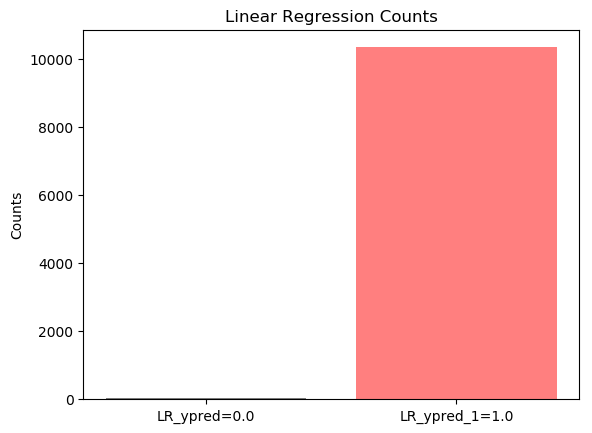

In [183]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR_ypred=0.0', 'LR_ypred_1=1.0')
y_pos = np.arange(len(objects))
performance = [len(SGD_ypred_0),len(SGD_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Linear Regression Counts')
 
plt.show()

In [184]:
from sklearn.ensemble import RandomForestRegressor

In [185]:
RandomForestRegressor = RandomForestRegressor(n_estimators=20)

In [186]:
RandomForestRegressor.fit(X_train_onehot, y_train_kera)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [187]:
y_pred_RF=RandomForestRegressor.predict(X_test_onehot)

In [188]:
RF_RMSE = sqrt(mean_squared_error(y_test_kera,y_pred_RF))
RF_RMSE

0.21328271725392414

In [189]:
RF_ypred_1 = []
RF_ypred_0 = []

In [190]:
for i in y_pred_RF:
    if i > 0.9 or i==0.9:
        RF_ypred_1.append(i)
    else:
        RF_ypred_0.append(i)

In [191]:
len(RF_ypred_0),len(RF_ypred_1)

(1425, 8974)

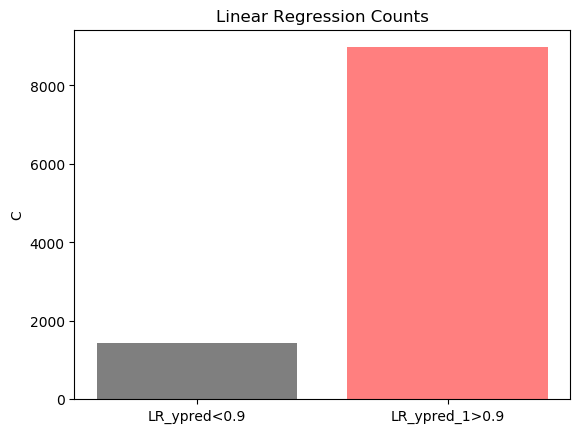

In [192]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR_ypred<0.9', 'LR_ypred_1>0.9')
y_pos = np.arange(len(objects))
performance = [len(RF_ypred_0),len(RF_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.xticks(y_pos, objects)
plt.ylabel('C')
plt.title('Linear Regression Counts')
 
plt.show()

In [193]:
from sklearn.linear_model import BayesianRidge

In [194]:
BayesianRidge = BayesianRidge()

In [195]:
BayesianRidge.fit(X_train_onehot.toarray(), y_train_kera)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [196]:
y_pred_BR=BayesianRidge.predict(X_test_onehot)

In [197]:
BR_RMSE = sqrt(mean_squared_error(y_test_kera,y_pred_BR))
BR_RMSE

0.206613651361948

In [198]:
BR_ypred_1 = []
BR_ypred_0 = []

In [199]:
for i in y_pred_BR:
    if i > 0.5 or i==0.5:
        BR_ypred_1.append(i)
    else:
        BR_ypred_0.append(i)

In [200]:
len(BR_ypred_0),len(BR_ypred_1)

(88, 10311)

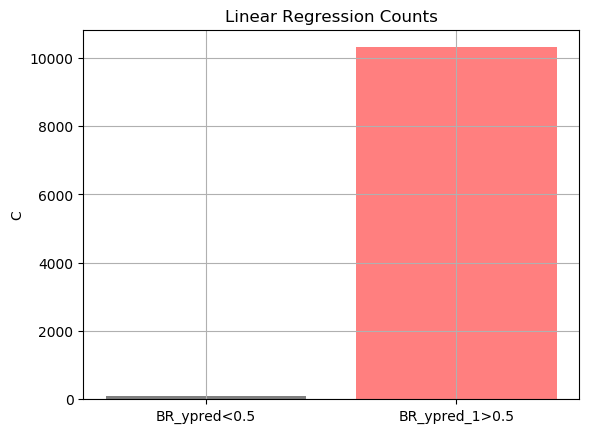

In [201]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('BR_ypred<0.5', 'BR_ypred_1>0.5')
y_pos = np.arange(len(objects))
performance = [len(BR_ypred_0),len(BR_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.grid()
plt.xticks(y_pos, objects)
plt.ylabel('C')
plt.title('Linear Regression Counts')
 
plt.show()

In [202]:
from sklearn.linear_model import LogisticRegression

In [203]:
LogisticRegression = LogisticRegression()

In [204]:
LogisticRegression.fit(X_train_onehot, y_train_kera)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [205]:
y_pred_LGR=LogisticRegression.predict(X_test_onehot)

In [206]:
from sklearn.metrics import mean_squared_error,r2_score
LGR_RMSE = sqrt(mean_squared_error(y_test_kera,y_pred_LGR))
LGR_RMSE

0.22533111834691347

In [207]:
LGR_ypred_1 = []
LGR_ypred_0 = []

In [208]:
for i in y_pred_LGR:
    if i > 0.5 or i==0.5:
        LGR_ypred_1.append(i)
    else:
        LGR_ypred_0.append(i)

In [209]:
len(LGR_ypred_0),len(LGR_ypred_1)

(125, 10274)

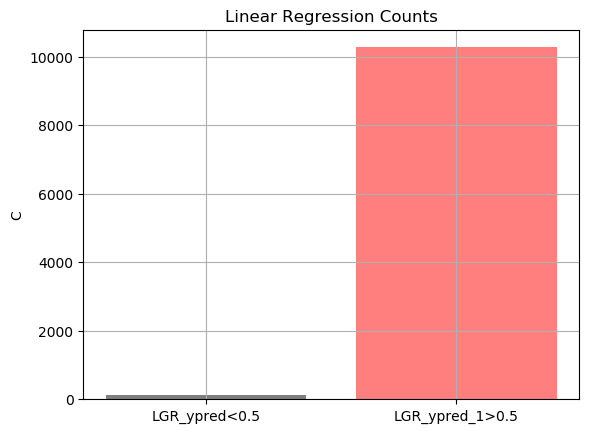

In [210]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LGR_ypred<0.5', 'LGR_ypred_1>0.5')
y_pos = np.arange(len(objects))
performance = [len(LGR_ypred_0),len(LGR_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.grid()
plt.xticks(y_pos, objects)
plt.ylabel('C')
plt.title('Linear Regression Counts')
 
plt.show()

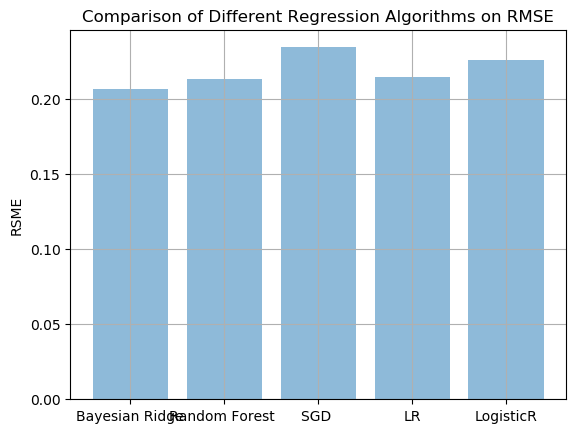

In [211]:
objects = ('Bayesian Ridge', 'Random Forest ', 'SGD ', 'LR','LogisticR')
y_pos = np.arange(len(objects))
performance = [BR_RMSE, RF_RMSE, SGD_RMSE, LR_RMSE,LGR_RMSE]

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.grid()
plt.ylabel('RSME')
plt.title('Comparison of Different Regression Algorithms on RMSE')
plt.show()

In [212]:
from sklearn.linear_model import SGDClassifier

In [213]:
SGDClassifier = SGDClassifier()

In [214]:
SGDClassifier.fit(X_train_onehot, y_train_kera)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [215]:
y_pred_SGD_Clf=SGDClassifier.predict(X_test_onehot)

In [216]:
y_pred_SGD_Clf

array([1, 1, 1, ..., 1, 1, 1])

In [217]:
from sklearn.metrics import f1_score
SGD_f1 = f1_score(y_pred_SGD_Clf, y_test_kera, average = 'weighted')

In [218]:
from collections import Counter

In [280]:
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'newComments'],
      dtype='object')

In [306]:
X = vect.fit_transform(df['newComments'],df['reviews.rating'])

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y_keras, test_size=0.3)

In [308]:
BayesianRidge = BayesianRidge.fit(X_train.toarray(),y_train)

In [309]:
y_pred = BayesianRidge.predict(X_test)

In [310]:
sqrt(mean_squared_error(y_test,y_pred))

0.20898779767141787

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  app.launch_new_instance()


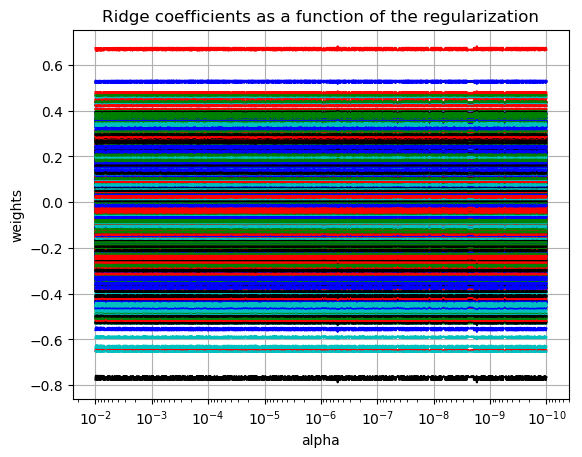

In [315]:
from sklearn import linear_model
n_alphas = 2000
alphas = np.logspace(-10, -2, n_alphas)
coefs = []
clf = linear_model.Ridge(fit_intercept=False)

# 根据不同的alpha训练出不同的模型参数
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y_keras)
    coefs.append(clf.coef_)

# 获得绘图句柄
ax = plt.gca()
# 参数中每一个维度使用一个颜色表示
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k'])

# 绘制alpha和对应的参数之间的关系图
ax.plot(alphas, coefs)
ax.set_xscale('log')    #x轴使用对数表示
ax.set_xlim(ax.get_xlim()[::-1])  # 将x轴反转，便于显示
plt.grid()
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()
